In [1]:
import numpy as np
import pandas as pd
import sympy as sym
import matplotlib.pyplot as plt
#import numba

# import scipy.linalg as sl
import scipy.sparse as ss
import scipy.sparse.linalg as ssl

# from sklearnex import patch_sklearn
# patch_sklearn();

## Grid Class

To do:
- scipy.sparse.dok_matrix: indeces suitable for 3D and efficient look up with O(1). 
- scipy.sparse.lil_matrix: LIL is a convenient format for constructing sparse matrices

In [2]:
class Grids():
    
    def __init__(self, shape, dims):
        self.dim = list(dim for dim in shape if dim > 1)
        self.dims = dims # lengths: dx, dy, dz
        self.dtype = np.single # np.single, np.double
        if len(self.dim) == 1:
            self.grid_type = '1D'
            self.shape = np.max(shape) + 2 # + 2 boundaries in 1D
            self.order = np.arange(self.shape) # natural order: 0, -1 are boundaries.
            self.blocks = np.ones(self.shape, dtype='int')
            self.iBlocks = self.blocks.copy()
            self.iBlocks[[0, -1]] = 0
            self.bBlocks = np.zeros(self.shape, dtype='int') #ss.lil_matrix(self.shape, dtype='int')
            self.bBlocks[[0, -1]] = 1            
            self.dx = self.blocks * self.dims[0] #/ shape[0]
            self.dy = self.blocks * self.dims[1] #/ shape[1]
            self.dz = self.blocks * self.dims[2] #/ shape[2]
            self.area = self.dy * self.dz
            self.z = np.zeros(self.shape) # grid tops
            self.pressures = (self.blocks * np.nan).astype(self.dtype)
            self.wells = {}
            self.boundaries = np.zeros(self.shape) # rate
        elif len(self.dim) == 2:
            self.grid_type = '2D'
        elif len(self.dim) == 3:
            self.grid_type = '3D'
        else:
            assert len(self.dim) <= 3, 'Geometry higher than 3 dimensions is not allowed!'
            
        self.units = {
            'transmissibility': 'STB/D-psi',
            'error': 'STB/D'
            }
        
        self.factors = {
            'transmissibility conversion': 0.001127,
            'gravity conversion': 0.21584*10**-3,
            'gravitational acceleration': 32.174,
        }
        
    def set_tops(self, values):
        self.z = self.blocks * values
        
    def set_rock_props(self, phi, k):
        self.phi = self.blocks * phi # np.zeros(self.shape) + phi
        self.k = self.blocks * k # np.zeros(self.shape) + k
        
    def set_fluid_props(self, mu=None, B=None, rho=None):
        if mu:
            self.mu = self.blocks * mu # np.zeros(self.shape) + mu
        if B:
            self.B = self.blocks * B # np.zeros(self.shape) + B
        # calc trans: after set_fluid_props() and set_rock_props()
        if rho:
            self.rho = self.blocks * rho
            self.fluid_gravity = self.factors['gravity conversion'] * self.rho * self.factors['gravitational acceleration']
        else:
            self.fluid_gravity = np.zeros(self.shape)
            
        self.get_trans()

    def get_trans(self):
        self.trans = self.factors['transmissibility conversion'] * (self.k * self.area) / (self.mu * self.B * self.dx)
        # test:
        self.trans = self.trans[:-1]
        return {'property': 'transmissibility', 'values': self.trans, 'unit': self.units['transmissibility']}
        
    def set_pressures(self, pressures):
        self.pressures = (self.blocks * pressures).astype('float') # np.zeros(self.shape) + pressures
        self.pressures[self.bBlocks.astype('bool')] = np.nan
    
    def set_wells(self, loc, q=None, pwf=None, r=None, s=None): # rate
        if not loc in self.wells.keys():
            r_eq = 0.14*(self.dx[loc]**2 + self.dy[loc]**2)**0.5
            self.wells[loc] = {'r_eq': r_eq}
        if q:
            self.wells[loc]['q'] = q
        if pwf:
            self.wells[loc]['pwf'] = pwf
        if r:
            self.wells[loc]['r'] = r
            if not s:
                G = 2*np.pi*self.factors['transmissibility conversion']*self.k[loc]*self.dz[loc] / np.log((r_eq/r*12))
                self.wells[loc]['G'] = G
        if s:
            self.wells[loc]['s'] = s
            G = 2*np.pi*self.factors['transmissibility conversion']*self.k[loc]*self.dz[loc] / (np.log(r_eq/r*12) + s)
            self.wells[loc]['G'] = G
        
    def set_boundaries(self, loc, conditions, values): # rate
        if len(self.dim) == 1:
            for i, c, v in zip(loc, conditions, values):
                if c == 'rate':
                    self.boundaries[i] = v
                if c == 'pressure':
                    self.pressures[i] = v
                if c == 'gradient':
                    self.boundaries[i] = self.trans[i] * self.dx[i] * v
        return self.boundaries
        
        
    def set_system(self, sys_type, units):
        self.sys_units = units
        if sys_type in ['incompressible']:
            self.RHS = 0
            self.sys_type = 'incompressible'
        else:
            self.RHS = 0
            print("System type is unknown!. RHS is set to 0 'incompressible'")
        
        
    def get_neighbours(self, index):
        if len(self.dim) == 1:
            assert index > 0 and index <= self.shape-2, 'grid index is out of range'
            if index == 1:
                return [index+1]
            if index == self.shape-2:
                return [index-1]
            else:
                return [index-1, index+1]
        
        
    def get_boundaries(self, index):
        if len(self.dim) == 1:
            assert index > 0 and index <= self.shape-2, 'grid index is out of range'
            if index == 1:
                return [index-1]
            if index == self.shape-2:
                return [index+1]
            else:
                return []
              
    def get_grid_flow_eq(self, i, verbose=False):
        
        iNeighbours = self.get_neighbours(i)
        iBoundaries = self.get_boundaries(i)
        
        if verbose: print(f'Neighbours: {iNeighbours} - Boundaries: {iBoundaries}')
        
        exec(f"p{i}=sym.Symbol('p{i}')")
        terms = []
        
        # 1. Flow from grid neighbours:
        for neighbour in iNeighbours:
            exec(f"p{neighbour} = sym.Symbol('p{neighbour}')")
            exec(f"term = self.trans[{neighbour}] * ((p{neighbour} - p{i}) - (self.fluid_gravity[{i}] * (self.z[{neighbour}]-self.z[{i}])))")
            terms.append(locals()['term'])
        
        # 2. Flow from grid boundaries:
        for boundary in iBoundaries:
            exec(f"p{boundary}=sym.Symbol('p{boundary}')")
            if not np.isnan(self.pressures[boundary]):
                exec(f"term = self.trans[{min(boundary,i)}] * 2 * ((p{boundary} - p{i}) - (self.fluid_gravity[{i}] * (self.z[{boundary}]-self.z[{i}])))")
                exec(f"term = term.subs(p{boundary}, {self.pressures[boundary]})")
            else:
                exec(f"term = self.boundaries[{boundary}]")
            terms.append(locals()['term'])
        
        # 3. Flow from grid well:
        if i in self.wells:
            if 'q' in self.wells[i]:
                terms.append(self.wells[i]['q'])
            else:
                exec(f"term = - self.wells[{i}]['G'] / (self.B[{i}]*self.mu[{i}]) * (p{i} - self.wells[{i}]['pwf'])")
                terms.append(locals()['term'])
        
        if verbose: print('terms:', terms)
        
        # Flow equation:
        flow_equation = sym.Eq(sum(terms), self.RHS)
        if flow_equation.lhs.as_coefficients_dict()[1] != 0:
            flow_equation = flow_equation.simplify()
        
        lhs = dict(sorted(flow_equation.lhs.as_coefficients_dict().items(), key=lambda x: str(x[0])))
        rhs = flow_equation.rhs
        
        return lhs, rhs
    
    def get_flow_eq(self):
        for i in self.order[self.iBlocks.astype('bool')]:
            lhs, rhs = self.get_grid_flow_eq(i)
            print(f'Grid {i}: {lhs}, {rhs}')

        
    def update_matrix(self, i, A, d, sparse=True):
        # arrays are passed by reference
        n = self.dim[0]
        lhs, rhs = self.get_grid_flow_eq(i)
        lhs = list(lhs.values())
        d[i-1] = np.array(rhs).astype(self.dtype)
        if i < 3:
            start = 0
        else: 
            start = i - 2
        if i+len(lhs) >= n: 
            end = n
        else:
            end = start + len(lhs)
            
        if sparse:
            array = A[i-1,start:end].toarray()[0]
        else:
            array = A[i-1,start:end]
        assert array.shape[0] == len(lhs), 'lhs of grid {} does not match the coefficients matrix'.format(i)
        A[i-1,start:end] = lhs # pass by reference
        
        
    def get_matrix(self, sparse=True, plot=False):
        if len(self.dim) == 1:
            n = self.dim[0]
            if sparse:
                A = ss.diags([-self.trans*2, self.trans[1:-1], self.trans[:-2]],
                             [0, 1, -1], 
                             shape=(n,n),
                             format='lil',
                             dtype=self.dtype) #“dia”, “csr”, “csc”, “lil”
                d = ss.lil_matrix((n,1), dtype=self.dtype) #ss.csc_matrix(d)
            else:
                A = np.zeros((n,n), dtype=self.dtype)
                d = np.zeros((n,1), dtype=self.dtype)
                # fill coefficient matrix tridiagonals with trans values:
                np.fill_diagonal(A, -self.trans*2)
                rng = np.arange(n-1)
                A[rng, rng+1] = self.trans[1:-1] # east trans for interior blocks To Do: confirm if this is right
                A[rng+1, rng] = self.trans[:-2] # west trans for interior blocks except last.To Do: confirm if this is right
            # check if there is pressure or flow in 'west' boundary:
            if not np.isnan(self.pressures[0]) or self.boundaries[0] != 0:
                self.update_matrix(1, A, d, sparse)
            # check if there is pressure or flow in 'east' boundary:
            elif not np.isnan(self.pressures[-1]) or self.boundaries[-1] != 0:
                self.update_matrix(-2, A, d, sparse)
            # check if there is a well in iBlocks:
            for i in self.wells.keys():
                self.update_matrix(i, A, d, sparse)
            if plot: 
                if sparse:
                    plt.imshow(A.toarray())
                else:
                    plt.imshow(A)
            return A, d
        
    def solve(self, sparse=True, verbose=False, check_MB=True):
        A, d = self.get_matrix(sparse)
        if verbose: print('A:', A), print('- d:', d)
        if sparse:
            output = ssl.spsolve(A.tocsc(), d)
        else:
            output = np.linalg.solve(A,d) # np.dot(np.linalg.inv(A),d)
        
        if len(self.dim) == 1:
            # update pressures: 
            self.pressures[1:-1] = output.flatten()
            # update wells:
            for loc in self.wells.keys():
                if 'q' in self.wells[loc]:
                    self.wells[loc]['pwf'] = self.pressures[loc] + \
                                            (self.wells[loc]['q']*self.B[loc]*self.mu[loc]/self.wells[loc]['G'])
                if 'pwf' in self.wells[loc]:
                    self.wells[loc]['q'] =  - self.wells[loc]['G'] / (self.B[loc]*self.mu[loc]) * \
                                              (self.pressures[loc] - self.wells[loc]['pwf'])
            # update baundaries:
            for boundary in np.argwhere(self.bBlocks != 0):
                i = 1 if boundary==0 else boundary-1
                if not np.isnan(self.pressures[boundary]):
                    self.boundaries[boundary] = self.trans[min(i,boundary)] * 2 * ((self.pressures[boundary] - self.pressures[i]) - (self.fluid_gravity[i] * (self.z[boundary]-self.z[i])))
        
        if check_MB:
            self.check_MB()
            
        return output.flatten()
    
    
    def check_MB(self, error=0.1):
        """Material Balance Check
        
        """
        if self.sys_type == 'incompressible':
            self.error = sum([self.wells[loc]['q'] for loc in self.wells]) + sum(self.boundaries)
        assert abs(self.error) < error, 'Material balance error ({}) higher than the allowed error ({}).'.format(self.error, error)
        
        if self.sys_type == 'slightly-compressible':
            self.incremental_error = 0
            self.cumulative_error = 0
        
    def plot(self, variable):
        exec(f"plt.imshow(self.{variable}[1:-1][:, np.newaxis])")
        
    def report(self, string=False, prop=None):
        props = vars(self)
        if string:
            if prop == None:
                print('Model Information:')
                for k, v in props.items():
                    print(f'    - {k}: {v}')
            elif prop in props.keys():
                    print(f' - {prop}: {props[prop]}')
            else:
                print('Unknown property! Use prop=None to print all available properties.')
        else:
            print(props)
            return pd.DataFrame(props)
            
    def __str__(self):
        self.report(string=True)
        return ''

In [53]:
class Solvers:
    # cfunc("CPointer(float64)(CPointer(float64), CPointer(float64))", nopython=True)
    @numba.njit #cfunc("float32[::1](float32[:,:], float32[::1])", nopython=True)
    def solve_matrix(A, d):
        output = np.dot(np.linalg.inv(A),d)
#         if sparse:
#             A_s = ss.csc_matrix(A)
#             d_s = ss.csc_matrix(d)
#             output = ssl.spsolve(A_s, d_s)
#         else:
#             output = np.linalg.solve(A,d) # np.dot(np.linalg.inv(A),d)
        # update pressures: 
        return output

## 1D Model

[[ 85.2012 -28.4004   0.       0.    ]
 [ 28.4004 -56.8008  28.4004   0.    ]
 [  0.      28.4004 -56.8008  28.4004]
 [  0.       0.      28.4004 -28.4004]]
[[227203.2]
 [     0. ]
 [     0. ]
 [   600. ]]


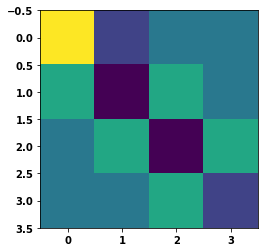

In [3]:
# Example 7.1:
model = Grids(shape=(4, 1, 1), dims=(300, 350, 40))
model.set_rock_props(phi=0.27, k=270)
model.set_fluid_props(mu=0.5 , B=1)
model.set_wells(loc=4, q=-600, s=1.5, r=3.5)
model.set_boundaries(loc=[0, -1], conditions=['pressure', 'rate'], values=[4000, 0])
model.set_system(sys_type='incompressible', units='us')
#print(model.get_flow_eq())
model.solve()
assert all(model.pressures[1:-1].round(2) == np.array([3989.4367685 , 3968.31030549, 3947.18384248, 3926.05737947], dtype=model.dtype).round(2))
#print(model)
model.plot('pressures')
# model.get_flow_eq()
A, d = model.get_matrix(plot=False, sparse=True)
print(A.toarray())
print(d.toarray())


In [5]:
# Example 7.3:
model = Grids(shape=(4, 1, 1), dims=(300, 350, 40))
model.set_rock_props(phi=0.27, k=270)
model.set_fluid_props(mu=0.5 , B=1)
model.set_wells(loc=4, s=1.5, r=3.5, pwf=3899)
model.set_boundaries(loc=[0, -1], conditions=['pressure', 'rate'], values=[4000, 0])
model.set_system(sys_type='incompressible', units='us')
model.solve()
assert model.wells[4]['q'].round(2) == round(-599.9563191829205, 2), 'wrong well rate estimate'
assert model.boundaries[0].round(2) == round(599.9563191829616, 2), 'wrong boundary rate estimate'
print(model)
# model.get_flow_eq()
# A, b = model.get_matrix(plot=True, sparse=True)
# A.toarray()

Model Information:
    - dim: [4]
    - dims: (300, 350, 40)
    - dtype: <class 'numpy.float32'>
    - grid_type: 1D
    - shape: 6
    - order: [0 1 2 3 4 5]
    - blocks: [1 1 1 1 1 1]
    - iBlocks: [0 1 1 1 1 0]
    - bBlocks: [1 0 0 0 0 1]
    - dx: [300 300 300 300 300 300]
    - dy: [350 350 350 350 350 350]
    - dz: [40 40 40 40 40 40]
    - area: [14000 14000 14000 14000 14000 14000]
    - z: [0. 0. 0. 0. 0. 0.]
    - pressures: [4000.     3989.4375 3968.313  3947.188  3926.0627       nan]
    - wells: {4: {'r_eq': 64.53681120105021, 'pwf': 3899, 'r': 3.5, 's': 1.5, 'G': 11.08453575337366, 'q': -599.9559100223227}}
    - boundaries: [599.95845   0.        0.        0.        0.        0.     ]
    - units: {'transmissibility': 'STB/D-psi', 'error': 'STB/D'}
    - factors: {'transmissibility conversion': 0.001127, 'gravity conversion': 0.00021584000000000002, 'gravitational acceleration': 32.174}
    - phi: [0.27 0.27 0.27 0.27 0.27 0.27]
    - k: [270 270 270 270 270 270]
  

In [6]:
# Example 7.4:
model = Grids(shape=(4, 1, 1), dims=(300, 350, 40))
model.set_rock_props(phi=0.27, k=270)
model.set_fluid_props(mu=0.5 , B=1)
model.set_wells(loc=4, q=-600, s=1.5, r=3.5)
model.set_boundaries(loc=[0, -1], conditions=['pressure', 'gradient'], values=[4000, -0.2])
model.set_system(sys_type='incompressible', units='us')
model.solve()
assert all(model.pressures[1:-1].round(2) == np.array([3959.436768496218, 3878.3103054886546, 3797.1838424810912, 3716.057379473528], dtype=model.dtype).round(2))
assert model.boundaries[-1].round(2) == round(-1704.024, 2), 'wrong boundary rate estimate'
assert model.boundaries[0].round(2) == round(2304.0240000000167, 2), 'wrong boundary rate estimate'
print(model)
# model.get_flow_eq()
# A, b = model.get_matrix(plot=True, sparse=True)
# A.toarray()

Model Information:
    - dim: [4]
    - dims: (300, 350, 40)
    - dtype: <class 'numpy.float32'>
    - grid_type: 1D
    - shape: 6
    - order: [0 1 2 3 4 5]
    - blocks: [1 1 1 1 1 1]
    - iBlocks: [0 1 1 1 1 0]
    - bBlocks: [1 0 0 0 0 1]
    - dx: [300 300 300 300 300 300]
    - dy: [350 350 350 350 350 350]
    - dz: [40 40 40 40 40 40]
    - area: [14000 14000 14000 14000 14000 14000]
    - z: [0. 0. 0. 0. 0. 0.]
    - pressures: [4000.     3959.4368 3878.3105 3797.184  3716.0576       nan]
    - wells: {4: {'r_eq': 64.53681120105021, 'q': -600.0000000000036, 'r': 3.5, 's': 1.5, 'G': 11.08453575337366, 'pwf': 3688.992884241089}}
    - boundaries: [ 2304.02405215     0.             0.             0.
     0.         -1704.024     ]
    - units: {'transmissibility': 'STB/D-psi', 'error': 'STB/D'}
    - factors: {'transmissibility conversion': 0.001127, 'gravity conversion': 0.00021584000000000002, 'gravitational acceleration': 32.174}
    - phi: [0.27 0.27 0.27 0.27 0.27 0.27]
 

In [7]:
# Example 7.5:
model = Grids(shape=(4, 1, 1), dims=(300, 350, 40))
model.set_tops([3212.73, 3182.34, 3121.56, 3060.78, 3000, 2969.62])
model.set_rock_props(phi=0.27, k=270)
model.set_fluid_props(mu=0.5 , B=1, rho=50)
model.set_wells(loc=4, q=-600, s=1.5, r=3.5)
model.set_boundaries(loc=[0, -1], conditions=['pressure', 'rate'], values=[4000, 0])
model.set_system(sys_type='incompressible', units='us')
model.solve()
assert all(model.pressures[1:-1].round(2) == np.array([3978.88469775 , 3936.65409325, 3894.42348876, 3852.19288426], dtype=model.dtype).round(2))
assert model.boundaries[0].round() == round(600.0000000000246), 'wrong boundary rate estimate'
assert model.wells[4]['pwf'].round(2) == round(3825.128151311277, 2), 'wrong pwf estimate'
assert model.wells[4]['r_eq'].round(2) == round(64.53681120105021, 2), 'wrong r_eq estimate'
assert model.wells[4]['G'].round(2) == round(11.08453575337366, 2), 'wrong G estimate'
print(model)
print(model.get_flow_eq())

Model Information:
    - dim: [4]
    - dims: (300, 350, 40)
    - dtype: <class 'numpy.float32'>
    - grid_type: 1D
    - shape: 6
    - order: [0 1 2 3 4 5]
    - blocks: [1 1 1 1 1 1]
    - iBlocks: [0 1 1 1 1 0]
    - bBlocks: [1 0 0 0 0 1]
    - dx: [300 300 300 300 300 300]
    - dy: [350 350 350 350 350 350]
    - dz: [40 40 40 40 40 40]
    - area: [14000 14000 14000 14000 14000 14000]
    - z: [3212.73 3182.34 3121.56 3060.78 3000.   2969.62]
    - pressures: [4000.     3978.8845 3936.6543 3894.4238 3852.193        nan]
    - wells: {4: {'r_eq': 64.53681120105021, 'q': -600.0000000000036, 'r': 3.5, 's': 1.5, 'G': 11.08453575337366, 'pwf': 3825.128382287964}}
    - boundaries: [600.01001209   0.           0.           0.           0.
   0.        ]
    - units: {'transmissibility': 'STB/D-psi', 'error': 'STB/D'}
    - factors: {'transmissibility conversion': 0.001127, 'gravity conversion': 0.00021584000000000002, 'gravitational acceleration': 32.174}
    - phi: [0.27 0.27 0.27

In [14]:
# Example 7.6:
model = Grids(shape=(4, 1, 1), dims=(300, 350, 40))
model.set_rock_props(phi=0.27, k=270)
model.set_fluid_props(mu=0.5 , B=1)
model.set_wells(loc=4, s=1.5, r=3.5, pwf=3850)
model.set_boundaries(loc=[0, -1], conditions=['pressure', 'rate'], values=[4000, 0])
model.set_system(sys_type='incompressible', units='us')
model.solve()
# a:
assert all(model.pressures[1:-1].round(2) == np.array([3984.31317453 , 3952.93952358, 3921.56587263, 3890.19222168], dtype=model.dtype).round(2))
assert model.wells[4]['q'].round(2) == round(-891.0242364102959, 2), 'wrong rate estimate'
assert model.wells[4]['G'].round(2) == round(11.08453575337366, 2), 'wrong G estimate'
print(model)
print(model.get_flow_eq())

Model Information:
    - dim: [4]
    - dims: (300, 350, 40)
    - dtype: <class 'numpy.float32'>
    - grid_type: 1D
    - shape: 6
    - order: [0 1 2 3 4 5]
    - blocks: [1 1 1 1 1 1]
    - iBlocks: [0 1 1 1 1 0]
    - bBlocks: [1 0 0 0 0 1]
    - dx: [300 300 300 300 300 300]
    - dy: [350 350 350 350 350 350]
    - dz: [40 40 40 40 40 40]
    - area: [14000 14000 14000 14000 14000 14000]
    - z: [0. 0. 0. 0. 0. 0.]
    - pressures: [4000.     3984.3132 3952.94   3921.5662 3890.1921       nan]
    - wells: {4: {'r_eq': 64.53681120105021, 'pwf': 3850, 'r': 3.5, 's': 1.5, 'G': 11.08453575337366, 'q': -891.022396225901}}
    - boundaries: [891.02094785   0.           0.           0.           0.
   0.        ]
    - units: {'transmissibility': 'STB/D-psi', 'error': 'STB/D'}
    - factors: {'transmissibility conversion': 0.001127, 'gravity conversion': 0.00021584000000000002, 'gravitational acceleration': 32.174}
    - phi: [0.27 0.27 0.27 0.27 0.27 0.27]
    - k: [270 270 270 270 2